Financial News Sentiment Analysis (FinBERT)

In [2]:
!pip install transformers datasets optuna torch scikit-learn matplotlib seaborn -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import torch


In [6]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


Load Dataset

In [9]:
# Load dataset
df = pd.read_csv("Financial_Sentiment_Analysis.csv")
print(df.head())

                                           headline sentiment
0  Strong dollar impacts emerging market currencies  negative
1           Bank earnings exceed expectations in Q3  positive
2  Strong dollar impacts emerging market currencies  negative
3       Energy sector gains as winter demand surges  positive
4  Government announces new fiscal stimulus package  positive


Exploratory Data Analysis (EDA)

a) Dataset Overview

In [13]:
print("Shape of dataset:", df.shape)
print("Columns:", df.columns)
print("Null values:\n", df.isnull().sum())

Shape of dataset: (1100, 2)
Columns: Index(['headline', 'sentiment'], dtype='object')
Null values:
 headline     0
sentiment    0
dtype: int64


b) Sentiment Distribution

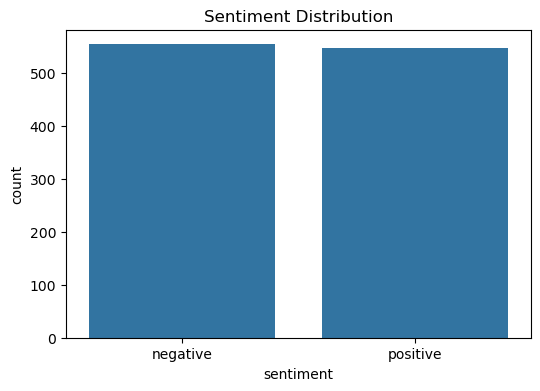

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="sentiment", order=df['sentiment'].value_counts().index)
plt.title("Sentiment Distribution")
plt.show()

c) Text Length Analysis

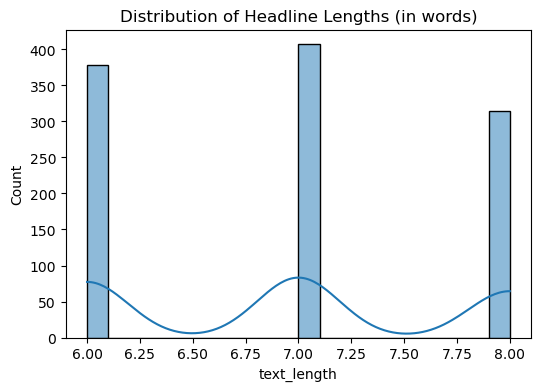

Average text length: 6.942727272727272


In [19]:
df["text_length"] = df["headline"].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(df["text_length"], bins=20, kde=True)
plt.title("Distribution of Headline Lengths (in words)")
plt.show()

print("Average text length:", df["text_length"].mean())

d) Sample Headlines by Sentiment

In [22]:
for label in df["sentiment"].unique():
    print(f"\nExamples of {label.upper()} headlines:")
    print(df[df["sentiment"]==label]["headline"].sample(3).to_list())


Examples of NEGATIVE headlines:
['Strong dollar impacts emerging market currencies', 'Federal Reserve raises interest rates amid inflation concerns', 'Investors worry about potential recession in 2025']

Examples of POSITIVE headlines:
['Unemployment claims fall, signaling job market strength', 'Tech stocks rally as market sentiment improves', 'Unemployment claims fall, signaling job market strength']


Data Preprocessing

In [25]:
# Encode labels
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["label"] = df["sentiment"].map(label_map)

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["headline"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"])

Tokenization

In [28]:
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=64)

train_dataset = Dataset.from_dict({**train_encodings, "labels": train_labels})
test_dataset = Dataset.from_dict({**test_encodings, "labels": test_labels})

Define Evaluation Metrics

In [70]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

Evaluate Pretrained FinBERT (Before Tuning)

In [75]:
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir="./baseline_results",
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    eval_strategy="epoch")

baseline_trainer = Trainer(
    model=base_model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

baseline_results = baseline_trainer.evaluate()
print("Baseline FinBERT Performance:", baseline_results)

C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\2684490442.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Baseline FinBERT Performance: {'eval_loss': 2.8791635036468506, 'eval_model_preparation_time': 0.003, 'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.6618, 'eval_samples_per_second': 132.389, 'eval_steps_per_second': 8.425}


C:\Users\venuk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\venuk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Optuna Hyperparameter Tuning + Fine-Tuning
Define Objective Function

In [78]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

def objective(trial):
    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
        per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        num_train_epochs=trial.suggest_int("num_train_epochs", 2, 5),
        weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy")

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics)

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result["eval_accuracy"]

Run Optuna Study

In [81]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_trial.params)

[I 2025-09-19 11:01:02,764] A new study created in memory with name: no-name-78791958-1325-4f28-b254-33c836ba16b4
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.252000,0.348194,0.840909,0.905566,1.000000,0.840909
2,0.240100,0.087554,1.000000,1.000000,1.000000,1.000000
3,0.090900,0.059684,1.000000,1.000000,1.000000,1.000000
4,0.070600,0.052495,1.000000,1.000000,1.000000,1.000000
5,0.065500,0.050535,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venu

[I 2025-09-19 11:03:48,560] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 1.5096408420229426e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 4.237007588617185e-05}. Best is trial 0 with value: 1.0.
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:18

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.003200,0.002416,1.000000,1.000000,1.000000,1.000000
2,0.001300,0.001025,1.000000,1.000000,1.000000,1.000000
3,0.000900,0.000695,1.000000,1.000000,1.000000,1.000000
4,0.000800,0.000616,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[I 2025-09-19 11:07:44,854] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 1.8733689810387933e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.0023186133572805703}. Best is trial 0 with value: 1.0.
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:18:

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.633500,0.731687,0.640909,0.737109,0.886735,0.640909
2,0.536100,0.196466,1.000000,1.000000,1.000000,1.000000
3,0.213000,0.109351,1.000000,1.000000,1.000000,1.000000
4,0.163800,0.095518,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venu

[I 2025-09-19 11:09:57,153] Trial 2 finished with value: 1.0 and parameters: {'learning_rate': 1.0697994041834752e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'weight_decay': 6.412542929589904e-05}. Best is trial 0 with value: 1.0.
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:18

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001600,0.001198,1.000000,1.000000,1.000000,1.000000
2,0.000700,0.000569,1.000000,1.000000,1.000000,1.000000
3,0.000600,0.000463,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[I 2025-09-19 11:13:07,736] Trial 3 finished with value: 1.0 and parameters: {'learning_rate': 3.112931836894243e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.000895699567870749}. Best is trial 0 with value: 1.0.
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:18: F

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.005800,0.003667,1.000000,1.000000,1.000000,1.000000
2,0.001900,0.001499,1.000000,1.000000,1.000000,1.000000
3,0.001400,0.000979,1.000000,1.000000,1.000000,1.000000
4,0.001000,0.000785,1.000000,1.000000,1.000000,1.000000
5,0.000900,0.000730,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_mem

[I 2025-09-19 11:17:13,545] Trial 4 finished with value: 1.0 and parameters: {'learning_rate': 2.5628511433091395e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.004658824404426366}. Best is trial 0 with value: 1.0.
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:18:

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.014200,0.009946,1.000000,1.000000,1.000000,1.000000
2,0.007300,0.006386,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[I 2025-09-19 11:18:49,004] Trial 5 finished with value: 1.0 and parameters: {'learning_rate': 1.577461950594572e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.0040443613899730085}. Best is trial 0 with value: 1.0.
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:18:

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.037200,0.014606,1.000000,1.000000,1.000000,1.000000
2,0.011200,0.008920,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[I 2025-09-19 11:20:05,341] Trial 6 finished with value: 1.0 and parameters: {'learning_rate': 2.5142543075874426e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.0036628574860483533}. Best is trial 0 with value: 1.0.
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:18

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.266900,0.063519,1.000000,1.000000,1.000000,1.000000
2,0.060500,0.048567,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[I 2025-09-19 11:21:20,492] Trial 7 finished with value: 1.0 and parameters: {'learning_rate': 4.933301891463894e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.0016156447261218335}. Best is trial 0 with value: 1.0.
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:18:

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.013600,0.011026,1.000000,1.000000,1.000000,1.000000
2,0.006500,0.005511,1.000000,1.000000,1.000000,1.000000
3,0.005600,0.004530,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[I 2025-09-19 11:24:34,709] Trial 8 finished with value: 1.0 and parameters: {'learning_rate': 6.807946613834936e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 2.7786336493109864e-06}. Best is trial 0 with value: 1.0.
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 1e-6, 5e-5),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-6, 0.1),
C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\3568678193.py:18:

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.008900,0.007071,1.000000,1.000000,1.000000,1.000000
2,0.004100,0.003393,1.000000,1.000000,1.000000,1.000000
3,0.003500,0.002756,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[I 2025-09-19 11:27:36,772] Trial 9 finished with value: 1.0 and parameters: {'learning_rate': 9.532652358861547e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 8.025988760261626e-05}. Best is trial 0 with value: 1.0.


Best hyperparameters: {'learning_rate': 1.5096408420229426e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 4.237007588617185e-05}


Train Final Model with Best Hyperparameters

In [85]:
best_params = study.best_trial.params

training_args = TrainingArguments(
    output_dir="./finbert_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy")

final_trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

final_trainer.train()

C:\Users\venuk\AppData\Local\Temp\ipykernel_20572\243639479.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.252000,0.348194,0.840909,0.905566,1.000000,0.840909
2,0.240100,0.087554,1.000000,1.000000,1.000000,1.000000
3,0.090900,0.059684,1.000000,1.000000,1.000000,1.000000
4,0.070600,0.052495,1.000000,1.000000,1.000000,1.000000
5,0.065500,0.050535,1.000000,1.000000,1.000000,1.000000


C:\Users\venuk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\venu

TrainOutput(global_step=140, training_loss=0.3954476122345243, metrics={'train_runtime': 174.5179, 'train_samples_per_second': 25.212, 'train_steps_per_second': 0.802, 'total_flos': 24872440269600.0, 'train_loss': 0.3954476122345243, 'epoch': 5.0})

Evaluate Final Fine-Tuned Model

In [88]:
final_results = final_trainer.evaluate()
print("Fine-tuned FinBERT Performance:", final_results)

C:\Users\venuk\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Fine-tuned FinBERT Performance: {'eval_loss': 0.08755424618721008, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 1.9958, 'eval_samples_per_second': 110.233, 'eval_steps_per_second': 14.03, 'epoch': 5.0}


Save Model

In [91]:
final_trainer.save_model("finbert_finetuned")
tokenizer.save_pretrained("finbert_finetuned")

('finbert_finetuned\\tokenizer_config.json',
 'finbert_finetuned\\special_tokens_map.json',
 'finbert_finetuned\\vocab.txt',
 'finbert_finetuned\\added_tokens.json',
 'finbert_finetuned\\tokenizer.json')

Predictions on New Headlines

In [94]:
new_texts = [ "Stock markets fall as investors fear recession",
    "Gold prices rise as demand increases",
    "Banking sector shows resilience in Q4 earnings"]

inputs = tokenizer(new_texts, truncation=True, padding=True, return_tensors="pt")
outputs = final_trainer.model(**inputs)
predictions = torch.argmax(outputs.logits, dim=1).numpy()

inv_label_map = {v: k for k, v in label_map.items()}
predicted_labels = [inv_label_map[p] for p in predictions]

list(zip(new_texts, predicted_labels))


[('Stock markets fall as investors fear recession', 'positive'),
 ('Gold prices rise as demand increases', 'positive'),
 ('Banking sector shows resilience in Q4 earnings', 'negative')]